# **Problem Statement:**
In many parts of West Africa, limited access to electricity continues to impede economic growth and social development. Prime Frontier Group, in collaboration with a regional government agency, is working to identify optimal sites for solar energy deployment.

This analysis aims to turn raw environmental and socio-economic data into actionable insights that can guide renewable energy investments.

We have been provided with a dataset containing solar irradiance, rural population density, grid access, infrastructure index, electricity cost and terrain ruggedness as features

Using this data, our goal is to:

Assess data quality and key trends through exploratory data analysis.

Engineer a custom metric, the Solar Access Score, to prioritize regions.

Model a classification task to flag high-priority regions for solar energy investment.

Recommend pilot deployment regions based on analytical insight and practical feasibility.

This notebook outlines a structured and reproducible pipeline designed to help Prime Frontier Group invest intelligently in the solar market.
Link to Notebook:https://colab.research.google.com/drive/1AzfFfSfBvyYRacl3bkcvUi5mRomwFLOK?usp=sharing


In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# **Task 1:Exploratory Data Analysis**

In [ ]:
df=pd.read_csv("/content/PrimeFrontier_SolarDeploymentDataset.csv")
df.head()

,Region,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Grid_Access_Percent,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score
0,Region_1,6.00,90,23.0,0.39,0.31,0.33
1,Region_2,5.36,206,73.3,0.88,0.35,0.55
2,Region_3,6.15,64,28.3,0.49,0.36,0.57
3,Region_4,7.02,350,53.0,0.22,0.22,0.98
4,Region_5,5.27,114,35.1,0.44,0.37,0.08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Region                        50 non-null     object 
 1   Solar_Irradiance_kWh_m2_day   50 non-null     float64
 2   Rural_Pop_Density_per_km2     50 non-null     int64  
 3   Grid_Access_Percent           50 non-null     float64
 4   Infrastructure_Index          50 non-null     float64
 5   Electricity_Cost_USD_per_kWh  50 non-null     float64
 6   Terrain_Ruggedness_Score      50 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.9+ KB


In [ ]:
df.describe()
# df["Grid_Access_Percent"].sum()

,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Grid_Access_Percent,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.275200,258.500000,52.816000,0.574800,0.277800,0.419800
std,0.933235,136.235578,20.202731,0.195242,0.081323,0.278732
min,3.540000,54.000000,20.000000,0.220000,0.110000,0.010000
25%,4.637500,134.500000,36.400000,0.407500,0.212500,0.220000
50%,5.270000,264.000000,50.750000,0.565000,0.275000,0.345000
75%,5.832500,376.750000,68.150000,0.747500,0.357500,0.602500
max,7.350000,498.000000,94.800000,0.900000,0.400000,0.980000


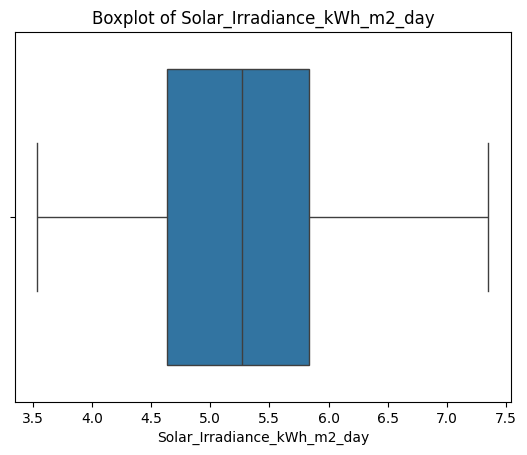

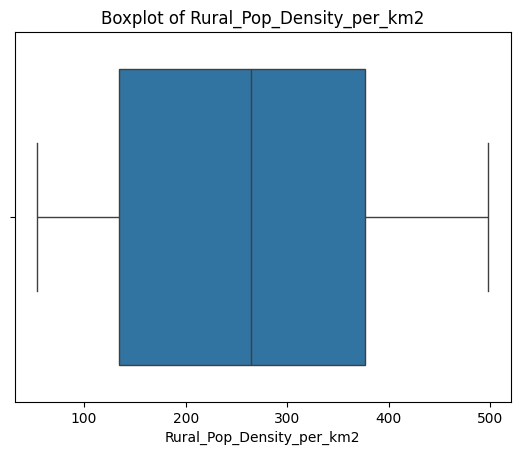

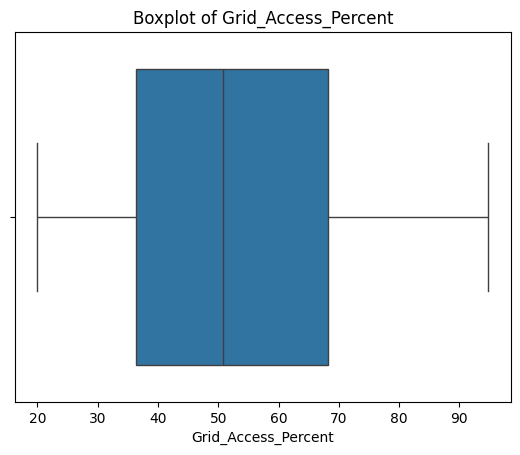

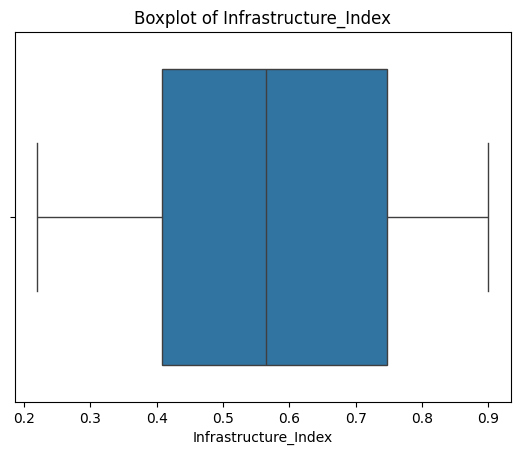

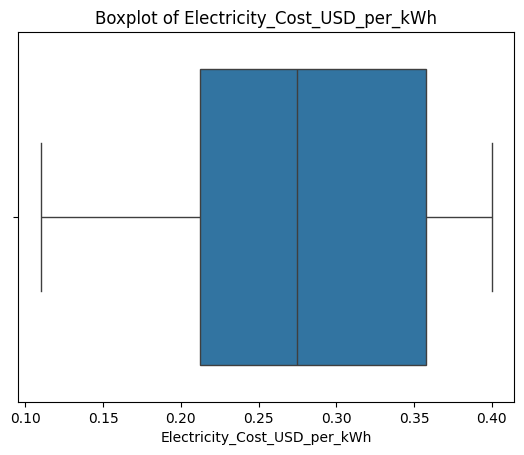

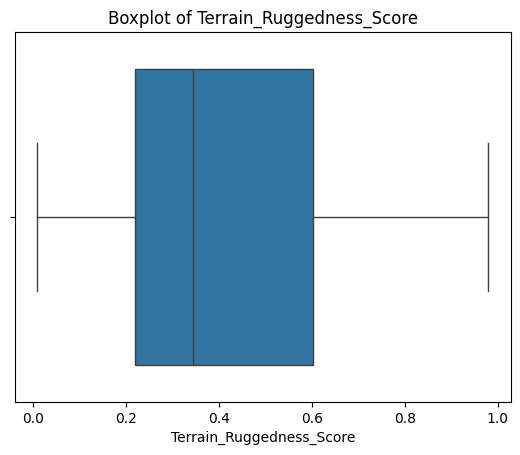

In [ ]:
# Checking for outliers
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

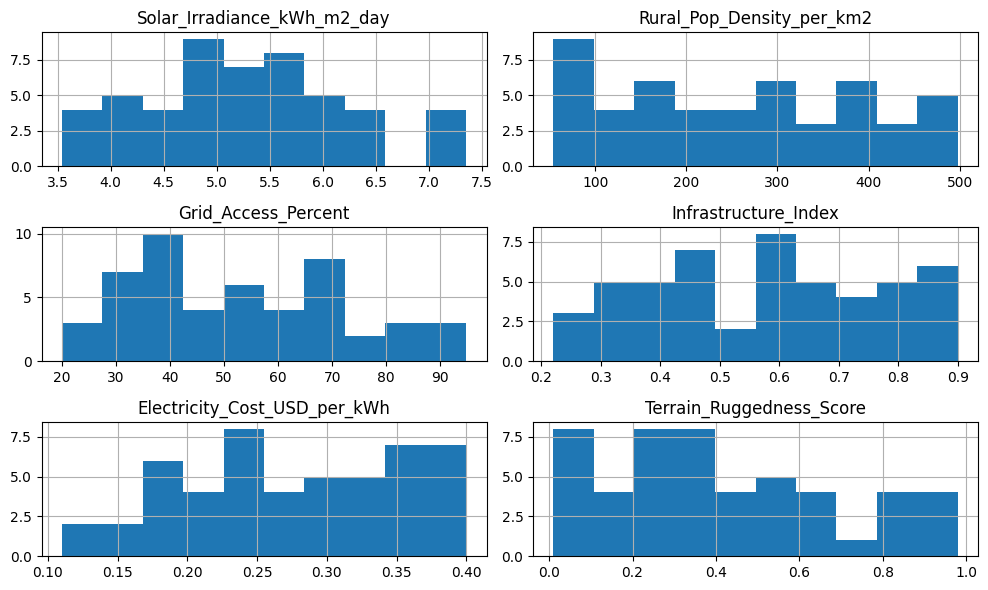

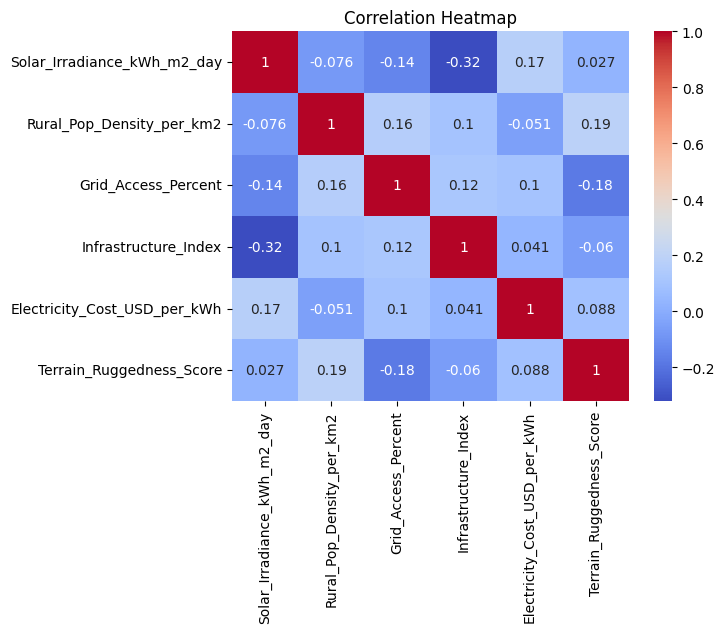

In [ ]:
# Histograms
df.hist(figsize=(10, 6), bins=10)
plt.tight_layout()
plt.show()

# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



   The dataset is clean with no missing value, outliers or inconsistent types, allowing us to proceed directly to feature engineering and modeling.

### 📝 Top 3 EDA Observations
1.   **Major Grid Access Disparities**
Looking at the grid access data, there's a really concerning spread here. The access ranges from just 20% to almost 95%, with an average of only 53%. What stands out is that half of these regions have less than 51% of their population connected to the grid. That's basically saying half our regions have more people WITHOUT electricity than with it, which is pretty alarming from an equity standpoint
2. **Untapped Solar Potential**
Something really interesting shows up when you look at the solar irradiance values. All 50 regions are getting a decent amount of sunlight — with an average of around 5.3 kWh/m²/day, which is actually pretty solid for solar energy generation. But when you pair that with the fact that grid access is so poor in half of these places, it really starts to feel like a missed opportunity. These areas have the natural resource (sunlight), but not the infrastructure. That makes them perfect candidates for solar deployment — they don’t need to wait for the grid to catch up.
3. **Electricity Cost Disparity**
Electricity prices across these regions are all over the place, ranging from $0.11 to $0.40 per kWh. That’s a big jump. Some places are clearly paying way more than others, and it adds up fast, especially in rural areas where income might already be low. In spots where electricity is that expensive, switching to solar could actually save people money long term. So from an affordability standpoint, this kind of cost difference is a big deal and worth paying attention to when deciding where to prioritize solar.


# **Task 2: Data Transformation & Feature Engineering**

In [ ]:
features_to_normalize = ['Solar_Irradiance_kWh_m2_day', 'Infrastructure_Index', 'Electricity_Cost_USD_per_kWh']
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[features_to_normalize])
df[['Solar_Irradiance_Scaled', 'Infrastructure_Scaled', 'Cost_Scaled']] = scaled_values
df.head()

,Region,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Grid_Access_Percent,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score,Solar_Irradiance_Scaled,Infrastructure_Scaled,Cost_Scaled
0,Region_1,6.00,90,23.0,0.39,0.31,0.33,0.645669,0.250000,0.689655
1,Region_2,5.36,206,73.3,0.88,0.35,0.55,0.477690,0.970588,0.827586
2,Region_3,6.15,64,28.3,0.49,0.36,0.57,0.685039,0.397059,0.862069
3,Region_4,7.02,350,53.0,0.22,0.22,0.98,0.913386,0.000000,0.379310
4,Region_5,5.27,114,35.1,0.44,0.37,0.08,0.454068,0.323529,0.896552


In [ ]:
# For Grid Access %, since it’s naturally bounded between 0 and 100, dividing by 100 is a straightforward and exact normalization.
df['Grid_Access_Normalized'] = df['Grid_Access_Percent'] / 100
df['Grid_Access_Inverse'] = 1 - df['Grid_Access_Normalized']
df.head()

,Region,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Grid_Access_Percent,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score,Solar_Irradiance_Scaled,Infrastructure_Scaled,Cost_Scaled,Grid_Access_Normalized,Grid_Access_Inverse
0,Region_1,6.00,90,23.0,0.39,0.31,0.33,0.645669,0.250000,0.689655,0.230,0.770
1,Region_2,5.36,206,73.3,0.88,0.35,0.55,0.477690,0.970588,0.827586,0.733,0.267
2,Region_3,6.15,64,28.3,0.49,0.36,0.57,0.685039,0.397059,0.862069,0.283,0.717
3,Region_4,7.02,350,53.0,0.22,0.22,0.98,0.913386,0.000000,0.379310,0.530,0.470
4,Region_5,5.27,114,35.1,0.44,0.37,0.08,0.454068,0.323529,0.896552,0.351,0.649


In [ ]:
weight_irradiance = 0.35
weight_grid_inverse = 0.25
weight_infrastructure = 0.20
weight_electricity_cost = 0.20

df['Solar_Access_Score'] = (
    weight_irradiance * df['Solar_Irradiance_Scaled'] +
    weight_grid_inverse * df['Grid_Access_Inverse'] +
    weight_infrastructure * df['Infrastructure_Scaled'] +
    weight_electricity_cost * df['Cost_Scaled']
)

In [ ]:
df.head()
print(df['Solar_Access_Score'].describe())


count    50.000000
mean      0.497439
std       0.122700
min       0.127133
25%       0.411839
50%       0.508162
75%       0.587743
max       0.757448
Name: Solar_Access_Score, dtype: float64


**Justification for Weights Assigned**
I assigned the Grid access inverse a slightly higher weight (25%) than electricity cost (20%) because areas with poor grid connectivity stand to benefit most urgently from solar solutions, making grid access a critical factor. Electricity cost, while important economically, was given a slightly lower weight to reflect that even regions with moderate costs but poor grid access or high irradiance can be prioritized.

# Task 3: Model a Classification Problem

In [ ]:
# METHOD 1
median_irradiance = df['Solar_Irradiance_kWh_m2_day'].median()
median_elec_cost = df['Electricity_Cost_USD_per_kWh'].median()
df['priority'] = np.where(
    (df['Grid_Access_Percent'] <50) &
    (df['Solar_Irradiance_kWh_m2_day'] > median_irradiance) &
    (df['Electricity_Cost_USD_per_kWh'] > median_elec_cost),1,0
)
df.head()
df["priority"].value_counts()

print(df['priority'].value_counts())


priority
0    45
1     5
Name: count, dtype: int64


In [ ]:
# METHOD 2
cutoff_score = np.percentile(df['Solar_Access_Score'], 70)
df['priority'] = (df['Solar_Access_Score'] >= cutoff_score).astype(int)
df.head()

df["Solar_Access_Score"].sort_values(ascending=False).head(3)

,Solar_Access_Score
6,0.757448
31,0.753574
47,0.699709


**Observation**
The median-based approach yielded only 5 priority regions out of 50, creating a highly imbalanced dataset with limited analytical value. This occurred because the method requires regions to simultaneously meet three independent conditions, which proves overly restrictive for practical implementation.
The score-based cutoff approach offers superior balance and flexibility. By selecting the top 30% based on our composite Solar Access Score, we achieve a more workable 15/35 distribution that provides sufficient priority regions for meaningful analysis while maintaining selectivity for high-potential areas.

In [ ]:
df.head()
df_model = df.copy()
cols_to_drop = [
    'Region',
    'Solar_Access_Score',
    'Solar_Irradiance_Scaled',
    'Infrastructure_Scaled',
    'Cost_Scaled',
    'Grid_Access_Normalized',
    'Grid_Access_Percent'
]

df_model.drop(columns=cols_to_drop, inplace=True)
target="priority"
X = df_model.drop(columns=[target])
y = df_model[target]
X.head()

,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score,Grid_Access_Inverse
0,6.00,90,0.39,0.31,0.33,0.770
1,5.36,206,0.88,0.35,0.55,0.267
2,6.15,64,0.49,0.36,0.57,0.717
3,7.02,350,0.22,0.22,0.98,0.470
4,5.27,114,0.44,0.37,0.08,0.649


In [ ]:
baseline_accuracy = y.value_counts(normalize=True).max()
baseline_accuracy

0.7

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=42)
X_train.head()
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_train_scaled_df.head()

,Solar_Irradiance_kWh_m2_day,Rural_Pop_Density_per_km2,Infrastructure_Index,Electricity_Cost_USD_per_kWh,Terrain_Ruggedness_Score,Grid_Access_Inverse
0,-1.610425,-0.595050,1.169055,0.577751,0.448628,-1.774214
1,0.341605,-0.846845,1.635123,-0.043487,-0.937234,-0.512204
2,-1.107072,1.508176,1.635123,-0.540477,-0.226535,-1.763827
3,-1.499933,-1.335623,0.599416,1.074741,0.057744,0.713451
4,-0.603718,1.419307,1.479767,0.080761,0.732908,1.663853


In [ ]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled_df, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled_df)
lr_test_pred = lr_model.predict(X_test_scaled_df)

# Metrics
lr_accuracy = accuracy_score(y_test, lr_test_pred)
lr_precision = precision_score(y_test, lr_test_pred)
lr_recall = recall_score(y_test, lr_test_pred)
lr_f1 = f1_score(y_test, lr_test_pred)
lr_cm = confusion_matrix(y_test, lr_test_pred)
# lr_train_pred, lr_test_pred

In [ ]:
# Feature importance (coefficients)
lr_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)
lr_feature_importance

,Feature,Coefficient,Abs_Coefficient
0,Solar_Irradiance_kWh_m2_day,1.508669,1.508669
2,Infrastructure_Index,1.321002,1.321002
3,Electricity_Cost_USD_per_kWh,1.289501,1.289501
5,Grid_Access_Inverse,0.721017,0.721017
1,Rural_Pop_Density_per_km2,-0.258356,0.258356
4,Terrain_Ruggedness_Score,-0.183386,0.183386


**Random Forest Model**

In [ ]:
print("RANDOM FOREST MODEL")

rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled_df, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train_scaled_df)
rf_test_pred = rf_model.predict(X_test_scaled_df)

# Metrics
rf_accuracy = accuracy_score(y_test, rf_test_pred)
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)

print(f"Test Accuracy: {rf_accuracy}")
print(f"Test Precision: {rf_precision}")
print(f"Test Recall: {rf_recall}")
print(f"Test F1-Score: {rf_f1:}")

print(f"\nConfusion Matrix:")
rf_cm = confusion_matrix(y_test, rf_test_pred)
print(rf_cm)


# Feature importance
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(f"Random forest feature importance:\n{rf_feature_importance}")

RANDOM FOREST MODEL
Test Accuracy: 0.9
Test Precision: 1.0
Test Recall: 0.6666666666666666
Test F1-Score: 0.8

Confusion Matrix:
[[7 0]
 [1 2]]
Random forest feature importance:
                        Feature  Importance
0   Solar_Irradiance_kWh_m2_day    0.274707
3  Electricity_Cost_USD_per_kWh    0.241436
2          Infrastructure_Index    0.157338
5           Grid_Access_Inverse    0.118668
1     Rural_Pop_Density_per_km2    0.110021
4      Terrain_Ruggedness_Score    0.097830


# **Interpretation From Random Forest Model**
Accuracy (0.9):
My model correctly classified 90% of the test samples.

Precision (1.0):
When my model predicts the positive class, it is always correct (no false positives).

Recall (0.667):
My model correctly identifies 66.7% of the actual positive cases (there is 1 false negative).

F1-Score (0.8):
The harmonic mean of precision and recall, balancing both concerns.

# **Model Comparison**

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic_Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1],
    'Random_Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1]
})

print(comparison_df.round(3))

# Determine best model
if rf_f1 > lr_f1:
    best_model = rf_model
    best_model_name = "Random Forest"
    print(f"\nBest Model: {best_model_name} (Higher F1-Score: {rf_f1:.3f})")
else:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    print(f"\nBest Model: {best_model_name} (Higher F1-Score: {lr_f1:.3f})")


      Metric  Logistic_Regression  Random_Forest
0   Accuracy                  1.0          0.900
1  Precision                  1.0          1.000
2     Recall                  1.0          0.667
3   F1-Score                  1.0          0.800

Best Model: Logistic Regression (Higher F1-Score: 1.000)


# **Task 4**
Business Insights: Solar Energy Pilot Project Recommendations
Top 3 Recommended Regions for Pilot Projects

Based on my Solar Access Score analysis ie
```
df["Solar_Access_Score"].sort_values(ascending=False).head(3)
```
I recommend the following regions for immediate pilot project implementation:

1.   Region 6 - Solar Access Score: 0.757448
2.   Region 31 - Solar Access Score: 0.753574
3.   Region 47 - Solar Access Score: 0.699709


**Why These Regions?**
1.  Optimal solar conditions: All three regions score in the top 6% of our 50-region analysis, combining high solar irradiance with favorable infrastructure and cost conditions
2.  Market readiness: These regions demonstrate the right mix of energy demand (higher electricity costs), infrastructure capability, and solar resource availability to ensure project success
3.  Risk mitigation: By selecting from our top-scoring regions, we minimize the chance of pilot failure due to poor solar conditions, infrastructure constraints, or unfavorable economics


**Risks and Unknowns**
1.   Regulatory environment: Our analysis doesn't include local
regulations, or government incentives that could significantly impact project feasibility.
2.  Seasonal variations: Our solar irradiance data may not capture full seasonal fluctuations or extreme weather patterns that could affect long-term performance.
3.  Community acceptance: Social factors, local politics, and cultural attitudes toward solar adoption are not captured in our technical metrics



**Additional Data for Improved Analysis**
1. Regulatory landscape: Permitting requirements, local energy policies, and government subsidy programs by region
2. Socioeconomic factors: Household income levels and community engagement metrics to assess market adoption potential
3. Competition: Existing energy providers, pricing structures, service quality issues, and local energy projects that could impact market dynamics
4. Environmental conditions: Weather patterns, dust/humidity levels, natural disaster frequency, and other factors affecting solar panel performance and maintenance needs